## Life history traits model  
Taylor Chapter 3  
model to predict age-structured life history traits of understudied Carcharhinid species

Model version: mixed effects, uses depthmax, litter & offspring (not relative); temperature and habitat added from previous model.  Model 1=full model with most covariates for a50 and s. Model 2=s covariates stripped out.

### Set up notebook

In [1]:
#import packages
import datetime 
from itertools import product
import logging
import pickle
import numpy as np
import pandas as pd
import scipy as sp
import os
from math import isnan
from sklearn.preprocessing import LabelEncoder
from collections import Counter
import seaborn as sns
import pymc3 as pm  
from theano import tensor as tt
from theano import shared
import arviz as az
import warnings

%matplotlib inline  
#%matplotlib inline is a magic function that renders the figure in a notebook (instead of displaying a dump of the figure object)
from matplotlib import pyplot as plt 
from matplotlib.offsetbox import AnchoredText
from matplotlib.ticker import FuncFormatter, StrMethodFormatter


In [2]:
# Aaron Helper function
def indexall(L):
    poo = []
    for p in L:
        if not p in poo:
            poo.append(p)
    Ix = np.array([poo.index(p) for p in L])
    return poo,Ix

def subindexall(short,long):
    poo = []
    out = []
    for s,l in zip(short,long):
        if not l in poo:
            poo.append(l)
            out.append(s)
    return indexall(out)

match = lambda a, b: [ b.index(x) if x in b else None for x in a ]
grep = lambda s, l: np.array([i for i in l if s in i])

# Function to standardize covariates
def stdise(x):
    return (x-np.mean(x))/(np.std(x)*2)

def invlogit(x):
    return np.exp(x)/(1+np.exp(x))

def gelplot(pj,vector,posy,csize=40,lwd50=7,lwd95=1):
    if np.percentile(vector,2.5)<0 and 0<np.percentile(vector,97.5):
        pj.plot(np.median(vector),posy,'.',markersize=csize,c='grey')
        pj.plot((np.percentile(vector,2.5),np.percentile(vector,97.5)),(posy,posy),linewidth=lwd95,c='grey')
        pj.plot((np.percentile(vector,25),np.percentile(vector,75)),(posy,posy),linewidth=lwd50,c='grey')
    else:
        pj.plot(np.median(vector),posy,'.',markersize=csize,c='black')
        pj.plot((np.percentile(vector,2.5),np.percentile(vector,97.5)),(posy,posy),linewidth=lwd95,c='black')
        pj.plot((np.percentile(vector,25),np.percentile(vector,75)),(posy,posy),linewidth=lwd50,c='black')
        
    if np.percentile(vector,25)<0 and 0<np.percentile(vector,75):
        pj.plot(np.median(vector),posy,'.',markersize=csize,c='white')

In [4]:
os.chdir('C:\\Users\\tmgor\\Dropbox\\Taylor Chapter 3\\Predict_Maturity\\Data\\for model\\in')
os.listdir() # list files in directory

['age_structured_traits.xlsx',
 'car_trait_covariates_v2.xlsx',
 'full_dataset.xlsx',
 'mat14_modelfit.jpg',
 'species_level_traits_v1.xlsx',
 'tmp_car_traits.xlsx',
 '~$car_trait_covariates_v2.xlsx',
 '~$full_dataset.xlsx']

### Import and structure data

In [5]:
# Import full dataset
data = pd.read_excel('full_dataset.xlsx')
#get rid of species that don't have full complement of trait data
data = data[data.param_complete==0]
data.head()

Species     Stock   Stock_Year  Age  maturity survivorship  \
0  Carcharhinus tilstoni  ABTP-SWP  ABTP-SWP-13    0  0.000000          NaN   
1  Carcharhinus tilstoni  ABTP-SWP  ABTP-SWP-13    1  0.000000          NaN   
2  Carcharhinus tilstoni  ABTP-SWP  ABTP-SWP-13    2  0.000000          NaN   
3  Carcharhinus tilstoni  ABTP-SWP  ABTP-SWP-13    3  0.000000          NaN   
4  Carcharhinus tilstoni  ABTP-SWP  ABTP-SWP-13    4  0.016088          NaN   

   fecundity (num female pups per year) notes model type  source_mat  ...  \
0                                   NaN   NaN        NaN  Harry 2013  ...   
1                                   NaN   NaN        NaN  Harry 2013  ...   
2                                   NaN   NaN        NaN  Harry 2013  ...   
3                                   NaN   NaN        NaN  Harry 2013  ...   
4                                   NaN   NaN        NaN  Harry 2013  ...   

  linf_cm growth_coeff_k lmax_cm age_max_yrs temp_pref  nursery depth_min  \
0   218.0          0.089   166.0        15.0      23.0      0.0       0.0   
1   218.0          0.089   166.0        15.0      23.0      0.0       0.0   
2   218.0          0.089   166.0        15.0      23.0      0.0       0.0   
3   218.0          0.089   166.0        15.0      23.0      0.0       0.0   
4   218.0          0.089   166.0        15.0      23.0      0.0       0.0   

  depth_max depth_ave param_complete  
0     150.0      75.0            0.0  
1     150.0      75.0            0.0  
2     150.0      75.0            0.0  
3     150.0      75.0            0.0  
4     150.0      75.0            0.0  

[5 rows x 37 columns]

In [6]:
#list columns
data.columns

Index(['Species', 'Stock', 'Stock_Year', 'Age', 'maturity', 'survivorship',
       'fecundity (num female pups per year)', 'notes', 'model type',
       'source_mat', 'source_sur', 'source_fec', 'source_m_link',
       'source_s_link', 'source_f_link', 'Cortes_2018', 'SA_mat', 'SA_sur',
       'SA_fec', 'FP_species', 'habitat', 'trophic_level', 'offspring_size_mm',
       'litter_size', 'interbirth_interval_yrs', 'age_50_maturity',
       'length_maturity_cm', 'linf_cm', 'growth_coeff_k', 'lmax_cm',
       'age_max_yrs', 'temp_pref', 'nursery', 'depth_min', 'depth_max',
       'depth_ave', 'param_complete'],
      dtype='object')

In [8]:
# make datafame of only stocks which have age-structured maturity data
# only data rows where SA-mat A
mdata= data[data.SA_mat=='A']
mdata.shape

(505, 37)

In [9]:
# make sure data is sorted properly
mdata = mdata.sort_values(by=['Stock_Year', 'Age'])

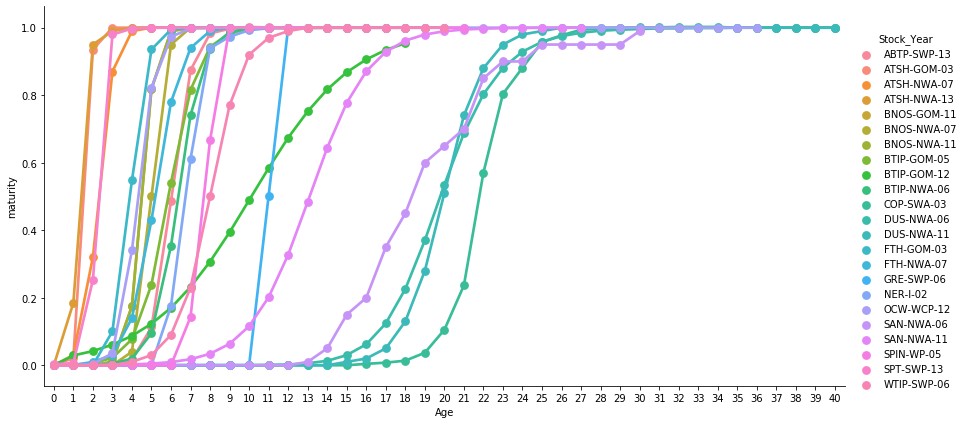

In [10]:
# visualise age-structured data
sns.catplot(x = "Age", y = "maturity", hue = "Stock_Year", height=6, aspect=2,
                kind="point", data = mdata);

## Format data

In [11]:
# Make arrays of response variables
AGE = mdata.Age.values
nobs = len(AGE)
MAT = mdata.maturity.values

In [12]:
# Make an index for stock-years 
# Puts an index value unique to the stock year for each row in df
StockYr, Is = indexall(mdata.Stock_Year.values)
nstocks = len(StockYr)
StockYr

['ABTP-SWP-13',
 'ATSH-GOM-03',
 'ATSH-NWA-07',
 'ATSH-NWA-13',
 'BNOS-GOM-11',
 'BNOS-NWA-07',
 'BNOS-NWA-11',
 'BTIP-GOM-05',
 'BTIP-GOM-12',
 'BTIP-NWA-06',
 'COP-SWA-03',
 'DUS-NWA-06',
 'DUS-NWA-11',
 'FTH-GOM-03',
 'FTH-NWA-07',
 'GRE-SWP-06',
 'NER-I-02',
 'OCW-WCP-12',
 'SAN-NWA-06',
 'SAN-NWA-11',
 'SPIN-WP-05',
 'SPT-SWP-13',
 'WTIP-SWP-06']

In [13]:
#Index of covariates
Sind = np.array([list(mdata.Stock_Year.values).index(S) for S in StockYr])

#make arrays of all the covariates
#put Sind after all of these so they match the length of StockYr
LMAX = mdata.lmax_cm.values[Sind]
HAB = mdata.habitat.values[Sind]
TROPH = mdata.trophic_level.values[Sind]
OFFSZ = mdata.offspring_size_mm.values[Sind]
#ROFFSZ = mdata.relative_offspring_size.values[Sind]
LITT = mdata.litter_size.values[Sind]
#RLITT = mdata.relative_litter_size.values[Sind]
INTR = mdata.interbirth_interval_yrs.values[Sind]
AMAT = mdata.age_50_maturity.values[Sind]
LMAT = mdata.length_maturity_cm.values[Sind]
LINF = mdata.linf_cm.values[Sind]
K = mdata.growth_coeff_k.values[Sind]
AMAX = mdata.age_max_yrs.values[Sind]
DEP = mdata.depth_ave.values[Sind]
DEPMAX = mdata.depth_max.values[Sind]
TEMP = mdata.temp_pref.values[Sind]

In [14]:
# standardise continuous covariates
LMAX = stdise(LMAX)
TROPH = stdise(TROPH)
OFFSZ = stdise(OFFSZ)
LITT = stdise(LITT)
INTR = stdise(INTR)
LMAT = stdise(LMAT)
LINF = stdise(LINF)
K = stdise(K)
AMAX = stdise(AMAX)
DEP = stdise(DEP)
DEPMAX = stdise(DEPMAX)
TEMP = stdise(TEMP)


In [15]:
# Index habitat types
Hab, HI = indexall(HAB)
nhabitats = len(Hab)
Hab, nhabitats

(['pelagic-neritic',
  'demersal',
  'reef-associated',
  'pelagic',
  'benthopelagic'],
 5)

# Bayes model

Maturity model has 2 parts to assess the 2 parameters which describe the maturity curve

$$m = \frac{1}{1+e^{-S}(a-a_{50})}$$


a50 null model:
$$
\small{
a_{50} \sim Normal(Ga_{50},\sigma a_{50}) \\ 
Ga_{50} \sim Uniform(1.5, 25)  \\
\sigma a_{50} \sim Exponential(0.5) 
}
$$



S null model:
$$
\small{
S \sim Normal(GS,\sigma S) \\
GS \sim Uniform(0.01, 10)  \\
\sigma S \sim Exponential(1) 
}
$$

### Visualise Priors

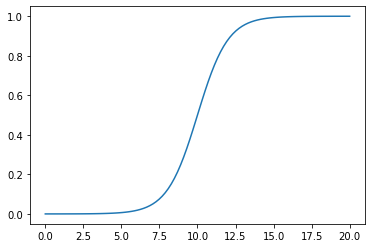

In [15]:
#make a figure of sigmoid with example maturity equation
def sigmoid(a):
    return(1/(1+np.exp(-1*(a-10))))
a = np.linspace(0,20,100)
plt.plot(a, sigmoid(a))

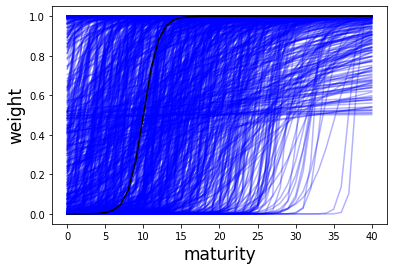

In [18]:
# try to visualise maturity slopes with prior a50 and S values
nsamp = 1000
a50 = np.random.normal(10, 10, nsamp)
S = np.random.exponential(1, nsamp)

ages = mdata.Age.unique()

#plot all possible ogives
[plt.plot(ages, 1/(1+np.exp(-S*(ages-a50))), c='blue', alpha=0.3) for a50,S in zip(a50, S)]
plt.xlabel('age', fontsize=10)
plt.ylabel('maturity', fontsize=10);

# a real ogive to see
plt.plot(ages, sigmoid(ages), c='black')

# Make it look nice
plt.xlabel('maturity', fontsize=17)
plt.ylabel('weight', fontsize=17);

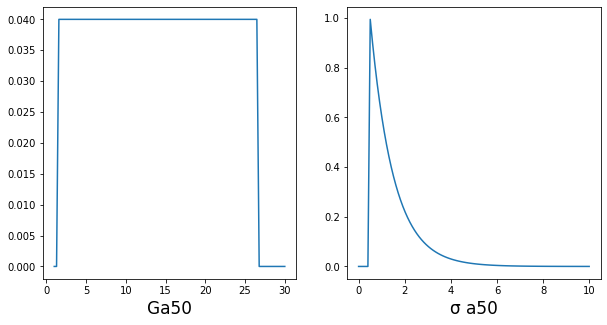

In [19]:
#visualise a50 priors here

# Setup multipanel figure
nrows, ncols = 1, 2
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10,5))
ax_ = axes.flatten()

# Plot range of Ga50 prior
# create 100 values between 1 and 30
x = np.linspace(1, 30, 100) 
ax_[0].plot(x, sp.stats.uniform.pdf(x, 1.5, 25))
# specify labels for chart 1
ax_[0].set_xlabel('Ga50', fontsize=17)

# Plot range of sigma prior
#create 100 values between -10 and 60
x = np.linspace(0, 10, 100)
#what is the likelihood of each potential sigma value given your uniform prior where the mean=0 and std dev=50
ax_[1].plot(x, sp.stats.expon.pdf(x, 0.5))
ax_[1].set_xlabel('σ a50', fontsize=17);

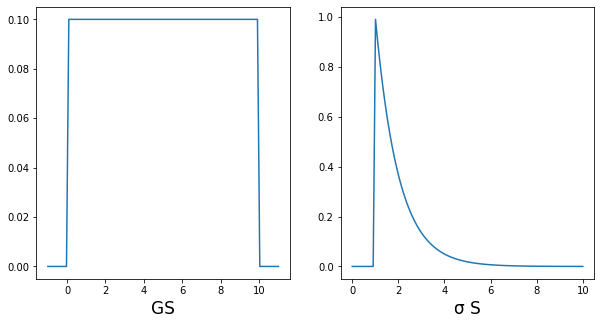

In [20]:
#visualise S priors here

# Setup multipanel figure
nrows, ncols = 1, 2
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10,5))
ax_ = axes.flatten()

# Plot range of GS prior
x = np.linspace(-1, 11, 100) #make the x axis
ax_[0].plot(x, sp.stats.uniform.pdf(x, 0.01, 10))
# specify labels for chart 1
ax_[0].set_xlabel('GS', fontsize=17)

# Plot range of sigma prior
#create 100 values between -10 and 60
x = np.linspace(0, 10, 100)
#what is the likelihood of each potential sigma value given your uniform prior where the mean=0 and std dev=50
ax_[1].plot(x, sp.stats.expon.pdf(x, 1))
ax_[1].set_xlabel('σ S', fontsize=17);

### Model Specification

In [21]:
# random effects model with all covariates
with pm.Model() as mat1:
    
    # Hierarchical a50
    Ga50 = pm.Uniform('Ga50', 1.5, 25) #mean a50 has uniform distribution from 1.5 to 25
    a50_sigma = pm.Exponential('a50_sigma', 0.5) #std dev of a50 is exponential distribution with lambda of 0.5
    a50 = pm.Normal('a50_', Ga50, a50_sigma, shape=nstocks) #likelihood of a50 values given distributions of Ga50 and sigma_a50 (I think... what is shape for?)
    # set up priors for slope values between a50 and covariates
    # first argument is just a name not an actual dataset - doesn't need to match name of data array
    β1 = pm.Normal('Lmax', 0, 3) 
   # β2 = pm.Normal('Linf', 0, 3) # don't use Linf bc same thing as Lmax, also effect too similar to K
    β3 = pm.Normal('Depth', 0, 3)
    β4 = pm.Normal('K', 0, 3)
    β5_ = pm.Normal ('Habitat', 0, tau=0.01, shape=nhabitats-1) # 
    β5 = tt.set_subtensor(tt.zeros(shape=nhabitats)[1:], β5_)
    β6 = pm.Normal('Interbirth_interval', 0, 3)
    β7 = pm.Normal('Amax', 0, 3)
    β8 = pm.Normal('Litter', 0, 3)
    β9 = pm.Normal('Offspring_size', 0, 3)
    β10 = pm.Normal('Trophic', 0, 3)
  #  β11 = pm.Normal('Lmat', 0, 3)  # Don't use Lmat because same thing as a50
    β12 = pm.Normal('Temperature', 0, 3)
    
    
    # Hierarchical S
    # S is the curve parameter determining steepness/shape of maturity curve
    # GS is mean of distribution describing what S is
    # S_sigma is standard dev of distribution around GS
    GS = pm.Uniform('GS', 0.01, 10) # Uniform distribution of possible S values from 0.01 to 10
    S_sigma = pm.Exponential('S_sigma', 1) #Exponential distribution of possible sigma values with lambda of 1
    S = pm.Normal('S_', GS, S_sigma, shape=nstocks) 
    
    # priors for covariates of S
    B1 = pm.Normal('Lmax-S', 0, 3)
    B3 = pm.Normal('Depth-S', 0, 3)
    B4 = pm.Normal('K-S', 0, 3)
    B5_ = pm.Normal ('Habitat-S', 0, tau=0.01, shape=nhabitats-1) # 
    B5 = tt.set_subtensor(tt.zeros(shape=nhabitats)[1:], β5_)
    B6 = pm.Normal('Interbirth_interval-S', 0, 3)
    B7 = pm.Normal('Amax-S', 0, 3)
    B8 = pm.Normal('Litter-S', 0, 3)
    B9 = pm.Normal('Offspring_size-S', 0, 3)
    B10 = pm.Normal('Trophic-S', 0, 3)
    # no lmat because treating S and a50 as if they behave separately
    B12 = pm.Normal('Temperature-S', 0, 3)
    
    
    # a50 model
    # put all parameters that influence a50 here (all the β params from above)
    mu_a50 = pm.Deterministic("mu_a50", a50 + β1*LMAX + β3*DEP + β4*K +  β5[HI] + β6*INTR + β7*AMAX + β8*LITT + β9*OFFSZ + β10*TROPH + β12*TEMP)
    
    # Growth (S) model
    mu_S = pm.Deterministic("mu_S", S + B1*LMAX + B3*DEP + B4*K + B5[HI] + B6*INTR + B7*AMAX + B8*LITT + B9*OFFSZ + B10*TROPH + B12*TEMP)
    
    # Growth model
    mu = 1/(1+tt.exp(-mu_S[Is]*(AGE-mu_a50[Is])))
    #mu = 1/(1+tt.exp(-S[Is]*(AGE-mu_a50[Is])))
    #mu = 1/(1+tt.exp(-S[Is]*(AGE-a50[Is])))

    # tt=under the hood modelling stuff - tensor flow package. makes exp work
    # Is is index values of stock codes

    # Likelihood
    S2 = pm.Uniform('S2', 0.0, 0.1) #variance for likelihood equation
    Yi = pm.Normal('Yi', mu, S2, observed=MAT)
    

In [22]:
# Sampling
# go back to 5000 for final run
with mat1:
    trace1 = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [S2, Temperature-S, Trophic-S, Offspring_size-S, Litter-S, Amax-S, Interbirth_interval-S, Habitat-S, K-S, Depth-S, Lmax-S, Sx, S_sigma, GS, Temperature, Trophic, Offspring_size, Litter, Amax, Interbirth_interval, Habitat, K, Depth, Lmax, a50x, a50_sigma, Ga50]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 26543 seconds.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


In [23]:
for RV in mat1.basic_RVs:
    print(RV.name, RV.logp(mat1.test_point))

Ga50_interval__ -1.3862943611198906
a50_sigma_log__ -1.0596601002984287
a50x -28.64817430640816
Lmax -2.0175508218727827
Depth -2.0175508218727827
K -2.0175508218727827
Habitat -12.886094504794874
Interbirth_interval -2.0175508218727827
Amax -2.0175508218727827
Litter -2.0175508218727827
Offspring_size -2.0175508218727827
Trophic -2.0175508218727827
Temperature -2.0175508218727827
GS_interval__ -1.3862943611198906
S_sigma_log__ -1.0596601002984287
Sx -12.705789153529404
Lmax-S -2.0175508218727827
Depth-S -2.0175508218727827
K-S -2.0175508218727827
Habitat-S -12.886094504794874
Interbirth_interval-S -2.0175508218727827
Amax-S -2.0175508218727827
Litter-S -2.0175508218727827
Offspring_size-S -2.0175508218727827
Trophic-S -2.0175508218727827
Temperature-S -2.0175508218727827
S2_interval__ -1.3862943611198904
Yi -28670.6496425569


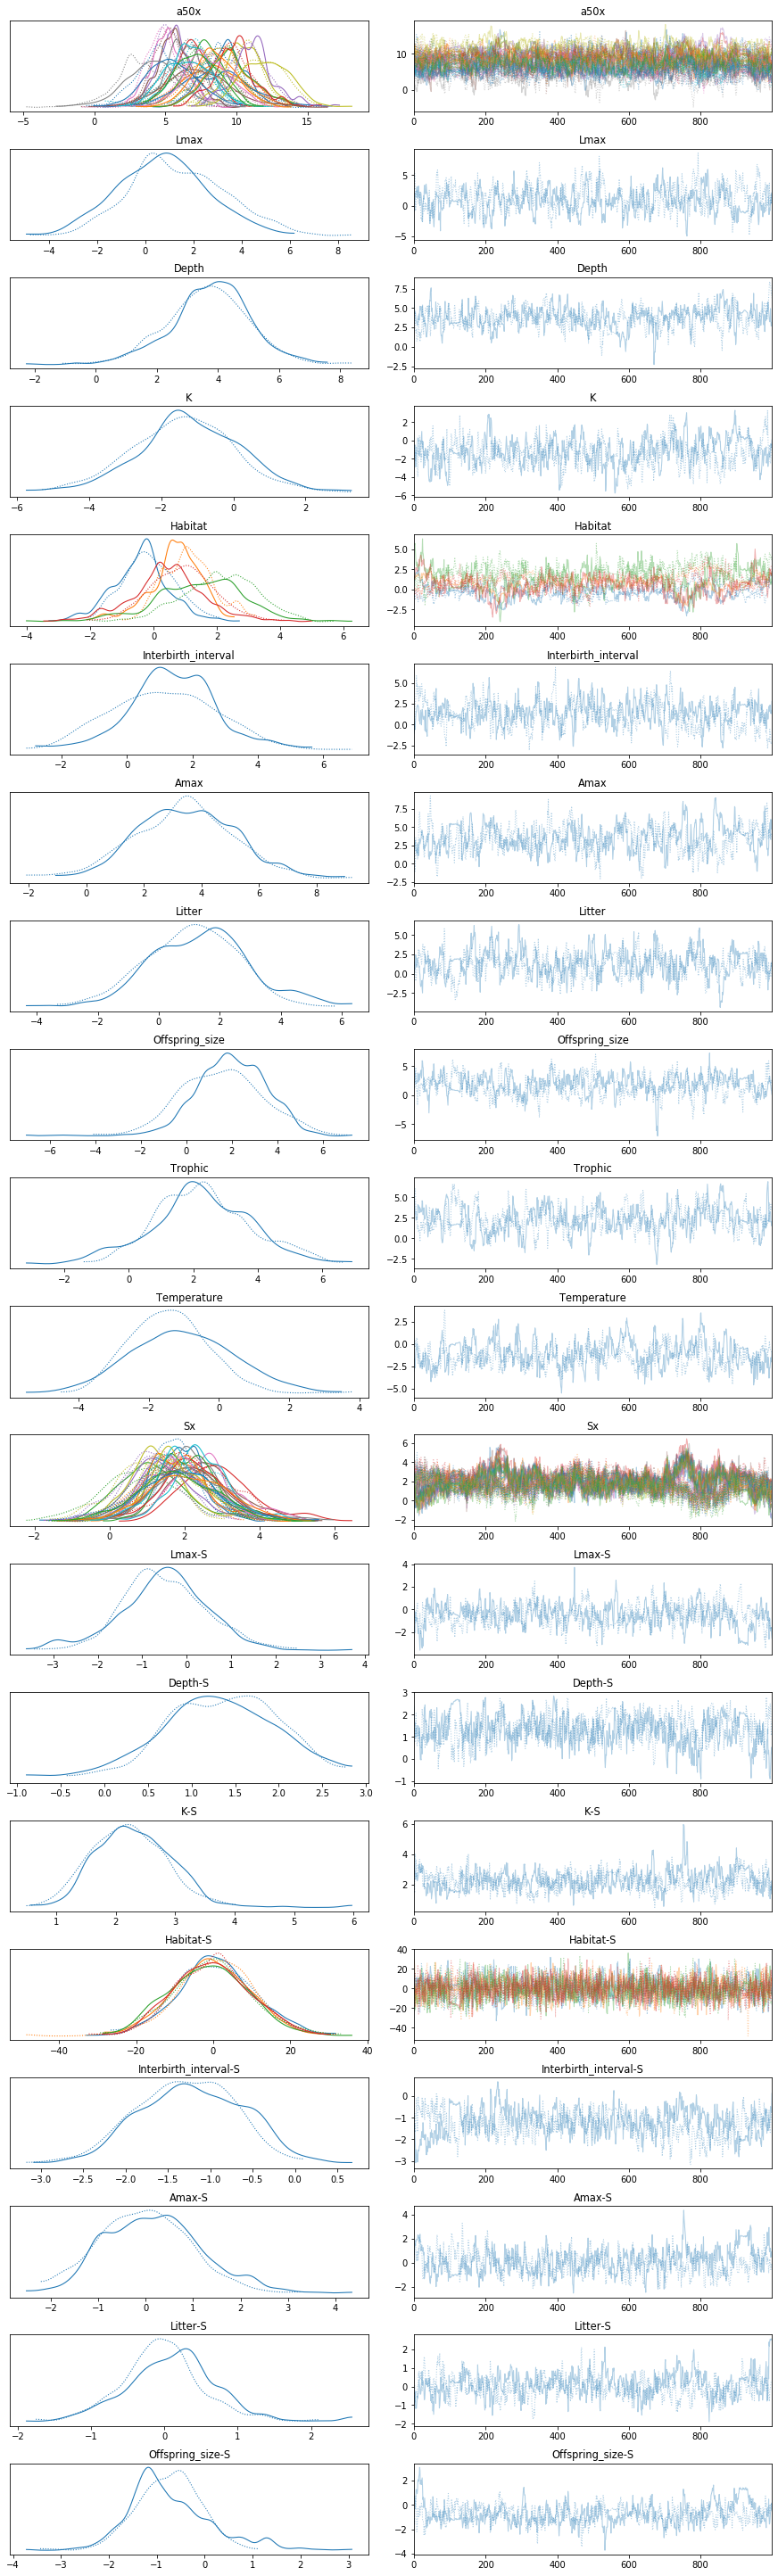

In [24]:
#check model performance
warnings.filterwarnings("ignore", category=UserWarning)
pm.traceplot(trace1);

In [25]:
pm.summary(trace1)
# looking for r-hat valeus of 1 - shows that model is converging

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
a50x[0]   9.011  1.520   6.141   11.850      0.111    0.081     186.0   179.0   
a50x[1]   8.391  2.149   4.472   12.369      0.244    0.173      77.0    77.0   
a50x[2]   7.582  1.605   4.585   10.462      0.232    0.165      48.0    48.0   
a50x[3]   6.636  1.605   3.644    9.521      0.232    0.165      48.0    48.0   
a50x[4]   5.450  1.219   3.235    7.752      0.191    0.136      41.0    41.0   
...         ...    ...     ...      ...        ...      ...       ...     ...   
mu_S[19]  0.658  0.010   0.639    0.676      0.000    0.000    2056.0  2054.0   
mu_S[20]  2.634  0.073   2.505    2.773      0.002    0.001    1867.0  1867.0   
mu_S[21]  5.103  0.501   4.353    6.044      0.040    0.032     153.0   125.0   
mu_S[22]  1.197  0.024   1.155    1.242      0.001    0.000    1984.0  1984.0   
S2        0.008  0.000   0.008    0.009      0.000    0.000    1089.0  1089.0   

          ess_bulk  ess_tail  r_hat  
a50x[0]      186.0     423.0   1.02  
a50x[1]       78.0     385.0   1.01  
a50x[2]       50.0      76.0   1.02  
a50x[3]       50.0      76.0   1.02  
a50x[4]       41.0     162.0   1.03  
...            ...       ...    ...  
mu_S[19]    2048.0    1263.0   1.00  
mu_S[20]    1870.0    1561.0   1.00  
mu_S[21]     447.0     119.0   1.01  
mu_S[22]    1982.0    1453.0   1.00  
S2          1088.0    1140.0   1.01  

[123 rows x 11 columns]

In [43]:
# fixed effects model with stripped out S
# model 13
with pm.Model() as mat2:
    
    # Hierarchical a50
    Ga50 = pm.Uniform('Ga50', 1.5, 25) #mean a50 has uniform distribution from 1.5 to 25
    #a50_sigma = pm.Exponential('a50_sigma', 0.5) #std dev of a50 is exponential distribution with lambda of 0.5
    #a50 = pm.Normal('a50x', Ga50, a50_sigma) #likelihood of a50 values given distributions of Ga50 and sigma_a50 (I think... what is shape for?)
    # set up priors for slope values between a50 and covariates
    # first argument is just a name not an actual dataset - doesn't need to match name of data array
    β1 = pm.Normal('Lmax', 0, 3) 
   # β2 = pm.Normal('Linf', 0, 3)
    β3 = pm.Normal('Depth', 0, 3)
   # β4 = pm.Normal('K', 0, 3)
    β5_ = pm.Normal ('Habitat', 0, tau=0.01, shape=nhabitats-1) # 
    β5 = tt.set_subtensor(tt.zeros(shape=nhabitats)[1:], β5_)
    β6 = pm.Normal('Interbirth_interval', 0, 3)
    β7 = pm.Normal('Amax', 0, 3)
    β8 = pm.Normal('Litter', 0, 3)
    β9 = pm.Normal('Offspring_size', 0, 3)
    β10 = pm.Normal('Trophic', 0, 3)
 #   β11 = pm.Normal('Lmat', 0, 3)
    β12 = pm.Normal('Temperature', 0, 3)
    
    # Hierarchical S
    # S is the curve parameter determining steepness/shape of maturity curve
    # GS is mean of distribution describing what S is
    # S_sigma is standard dev of distribution around GS
     
    GS = pm.Uniform('GS', 0.01, 10) # Uniform distribution of possible S values from 0.01 to 10
   # S_sigma = pm.Exponential('S_sigma', 1) #Exponential distribution of possible sigma values with lambda of 1
   # S = pm.Normal('Sx', GS, S_sigma, shape=nstocks) 
    
    # now put all the priors for covariates of S
   # B1 = pm.Normal('Lmax-S', 0, 3)
   # B3 = pm.Normal('Depth-S', 0, 3)
    B4 = pm.Normal('K-S', 0, 3)
   # β5 = pm.Normal ('Habitat', 0, 3) # How to set this up for a categorical variable?
   # B6 = pm.Normal('Interbirth_interval-S', 0, 3)
    B7 = pm.Normal('Amax-S', 0, 3)
  #  B8 = pm.Normal('Litter-S', 0, 3)
  #  B9 = pm.Normal('Offspring_size-S', 0, 3)
    B10 = pm.Normal('Trophic-S', 0, 3)
 #   B11 = pm.Normal('Lmat-S', 0, 3)
    B12 = pm.Normal('Temperature-S', 0, 3)
    
    # a50 model
    # put all parameters that influence a50 here (all the β params from above)
    mu_a50 = pm.Deterministic("mu_a50", Ga50 + β1*LMAX + β3*DEP + β5[HI] + β6*INTR + β7*AMAX + β8*LITT + β9*OFFSZ + β10*TROPH + β12*TEMP)
 
    # Growth (S) model
    #put all parameters that influence S here 
    mu_S = pm.Deterministic("mu_S", GS + B4*K + B7*AMAX + B10*TROPH + B12*TEMP)
    
    # Growth model
    # should there be an index for mu_S here? shouldn't there be just one s value?
    #mu = 1/(1+tt.exp(-S[Is]*(AGE-a50[Is])))
    mu = 1/(1+tt.exp(-mu_S[Is]*(AGE-mu_a50[Is])))

    # tt=under the hood modelling stuff - tensor flow package. makes exp work
    # Is is index values of stock codes

    # Likelihood
    S2 = pm.Uniform('S2', 0.0, 0.1) 
    Yi = pm.Normal('Yi', mu, S2, observed=MAT)
    

In [44]:
# Sampling
# go back to 5000 for final run
with mat2:
    trace2 = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [S2, Temperature-S, Trophic-S, Amax-S, K-S, GS, Temperature, Trophic, Offspring_size, Litter, Amax, Interbirth_interval, Habitat, Depth, Lmax, Ga50]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 9416 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.


In [18]:
warnings.filterwarnings("ignore")
# warnings.filterwarnings("ignore", category=UserWarning)

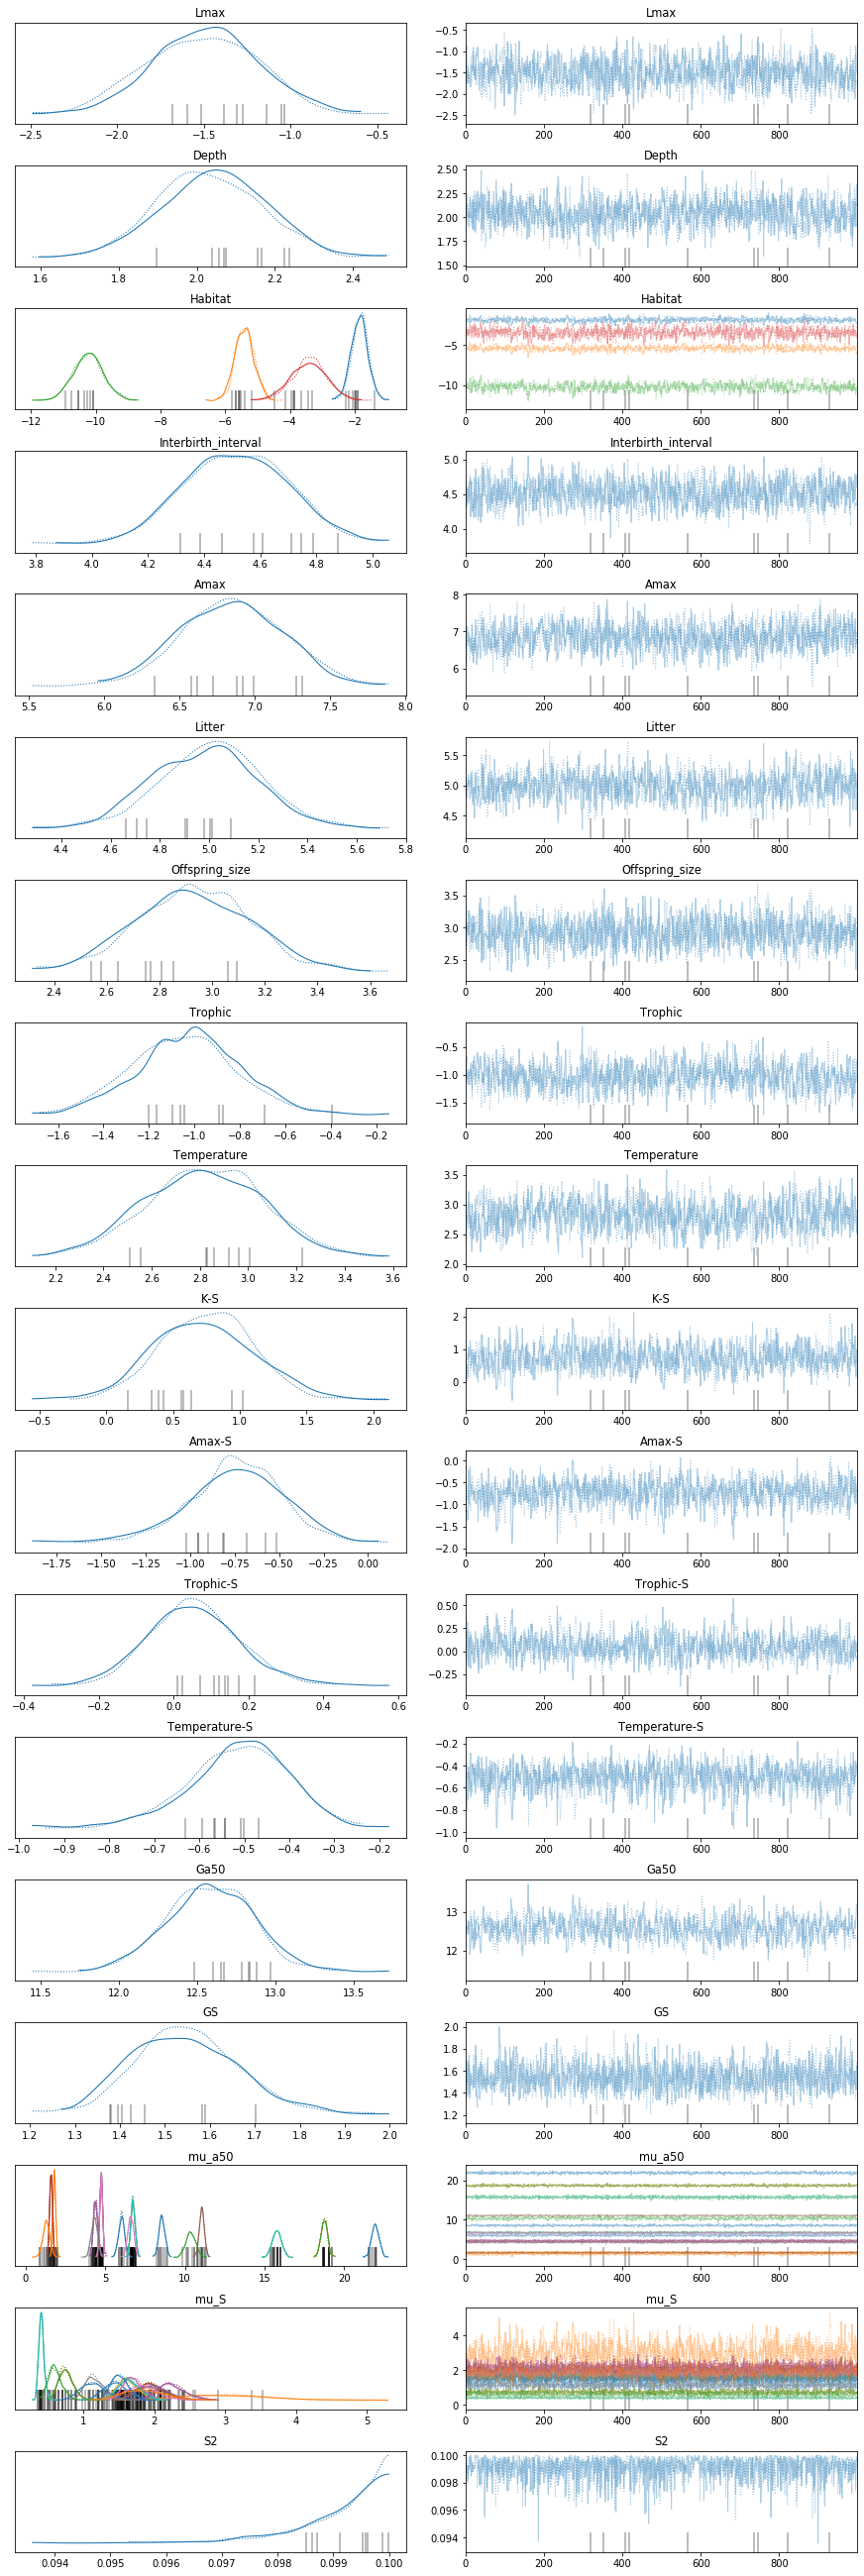

In [45]:
#check model performance
pm.traceplot(trace2);

In [46]:
pm.summary(trace2)
# looking for r-hat valeus of 1 - shows that model is converging

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  \
Lmax        -1.498  0.316  -2.098   -0.938      0.010    0.007    1001.0   
Depth        2.041  0.136   1.788    2.287      0.004    0.003     945.0   
Habitat[0]  -1.844  0.255  -2.323   -1.373      0.009    0.006     789.0   
Habitat[1]  -5.404  0.286  -5.906   -4.843      0.011    0.008     665.0   
Habitat[2] -10.236  0.458 -11.094   -9.364      0.017    0.012     692.0   
...            ...    ...     ...      ...        ...      ...       ...   
mu_S[19]     0.405  0.038   0.335    0.476      0.001    0.001    2203.0   
mu_S[20]     1.513  0.119   1.286    1.719      0.003    0.002    1431.0   
mu_S[21]     1.875  0.292   1.357    2.431      0.009    0.007     967.0   
mu_S[22]     0.596  0.094   0.442    0.787      0.003    0.002    1183.0   
S2           0.099  0.001   0.098    0.100      0.000    0.000    2031.0   

            ess_sd  ess_bulk  ess_tail  r_hat  
Lmax        1001.0    1005.0    1435.0   1.00  
Depth        945.0     944.0    1242.0   1.00  
Habitat[0]   783.0     783.0     881.0   1.00  
Habitat[1]   665.0     666.0     954.0   1.00  
Habitat[2]   692.0     688.0     848.0   1.00  
...            ...       ...       ...    ...  
mu_S[19]    2202.0    2174.0    1656.0   1.00  
mu_S[20]    1413.0    1450.0    1352.0   1.00  
mu_S[21]     938.0     984.0     944.0   1.01  
mu_S[22]    1144.0    1237.0    1191.0   1.00  
S2          2026.0    1064.0     641.0   1.00  

[65 rows x 11 columns]

In [41]:
# random effects model with stripped out covariates
with pm.Model() as mat3:
    
    # Hierarchical a50
    Ga50 = pm.Uniform('Ga50', 1.5, 25) #mean a50 has uniform distribution from 1.5 to 25
    a50_sigma = pm.Exponential('a50_sigma', 0.5) #std dev of a50 is exponential distribution with lambda of 0.5
    a50 = pm.Normal('a50_', Ga50, a50_sigma, shape=nstocks) #likelihood of a50 values given distributions of Ga50 and sigma_a50 (I think... what is shape for?)
    # set up priors for slope values between a50 and covariates
    # first argument is just a name not an actual dataset - doesn't need to match name of data array
    β1 = pm.Normal('Lmax', 0, 3) 
   # β2 = pm.Normal('Linf', 0, 3) # don't use Linf bc same thing as Lmax, also effect too similar to K
    β3 = pm.Normal('Depth', 0, 3)
  #  β4 = pm.Normal('K', 0, 3)
    β5_ = pm.Normal ('Habitat', 0, tau=0.01, shape=nhabitats-1) # 
    β5 = tt.set_subtensor(tt.zeros(shape=nhabitats)[1:], β5_)
    β6 = pm.Normal('Interbirth_interval', 0, 3)
    β7 = pm.Normal('Amax', 0, 3)
    β8 = pm.Normal('Litter', 0, 3)
    β9 = pm.Normal('Offspring_size', 0, 3)
    β10 = pm.Normal('Trophic', 0, 3)
  #  β11 = pm.Normal('Lmat', 0, 3)  # Don't use Lmat because same thing as a50
    β12 = pm.Normal('Temperature', 0, 3)
    
    
    # Hierarchical S
    # S is the curve parameter determining steepness/shape of maturity curve
    # GS is mean of distribution describing what S is
    # S_sigma is standard dev of distribution around GS
    GS = pm.Uniform('GS', 0.01, 10) # Uniform distribution of possible S values from 0.01 to 10
    S_sigma = pm.Exponential('S_sigma', 1) #Exponential distribution of possible sigma values with lambda of 1
    S = pm.Normal('S_', GS, S_sigma, shape=nstocks) 
    
    # priors for covariates of S
   # B1 = pm.Normal('Lmax-S', 0, 3)
    #B3 = pm.Normal('Depth-S', 0, 3)
    B4 = pm.Normal('K-S', 0, 3)
  #  B5_ = pm.Normal ('Habitat-S', 0, tau=0.01, shape=nhabitats-1) # 
  #  B5 = tt.set_subtensor(tt.zeros(shape=nhabitats)[1:], β5_)
  #  B6 = pm.Normal('Interbirth_interval-S', 0, 3)
    B7 = pm.Normal('Amax-S', 0, 3)
  #  B8 = pm.Normal('Litter-S', 0, 3)
  #  B9 = pm.Normal('Offspring_size-S', 0, 3)
    B10 = pm.Normal('Trophic-S', 0, 3)
    # no lmat because treating S and a50 as if they behave separately
    B12 = pm.Normal('Temperature-S', 0, 3)
    
    
    # a50 model
    # put all parameters that influence a50 here (all the β params from above)
    mu_a50 = pm.Deterministic("mu_a50", a50 + β1*LMAX + β3*DEP +  β5[HI] + β6*INTR + β7*AMAX + β8*LITT + β9*OFFSZ + β10*TROPH + β12*TEMP)
    
    # Growth (S) model
    mu_S = pm.Deterministic("mu_S", S + B4*K + B7*AMAX + B10*TROPH + B12*TEMP)
    
    # Growth model
    mu = 1/(1+tt.exp(-mu_S[Is]*(AGE-mu_a50[Is])))
    #mu = 1/(1+tt.exp(-S[Is]*(AGE-mu_a50[Is])))
    #mu = 1/(1+tt.exp(-S[Is]*(AGE-a50[Is])))

    # tt=under the hood modelling stuff - tensor flow package. makes exp work
    # Is is index values of stock codes

    # Likelihood
    S2 = pm.Uniform('S2', 0.0, 0.1) #variance for likelihood equation
    Yi = pm.Normal('Yi', mu, S2, observed=MAT)
    

In [42]:
# Sampling
# go back to 5000 for final run
with mat3:
    trace3 = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [S2, Temperature-S, Trophic-S, Amax-S, K-S, Sx, S_sigma, GS, Temperature, Trophic, Offspring_size, Litter, Amax, Interbirth_interval, Habitat, Depth, Lmax, a50x, a50_sigma, Ga50]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 22226 seconds.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 74 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


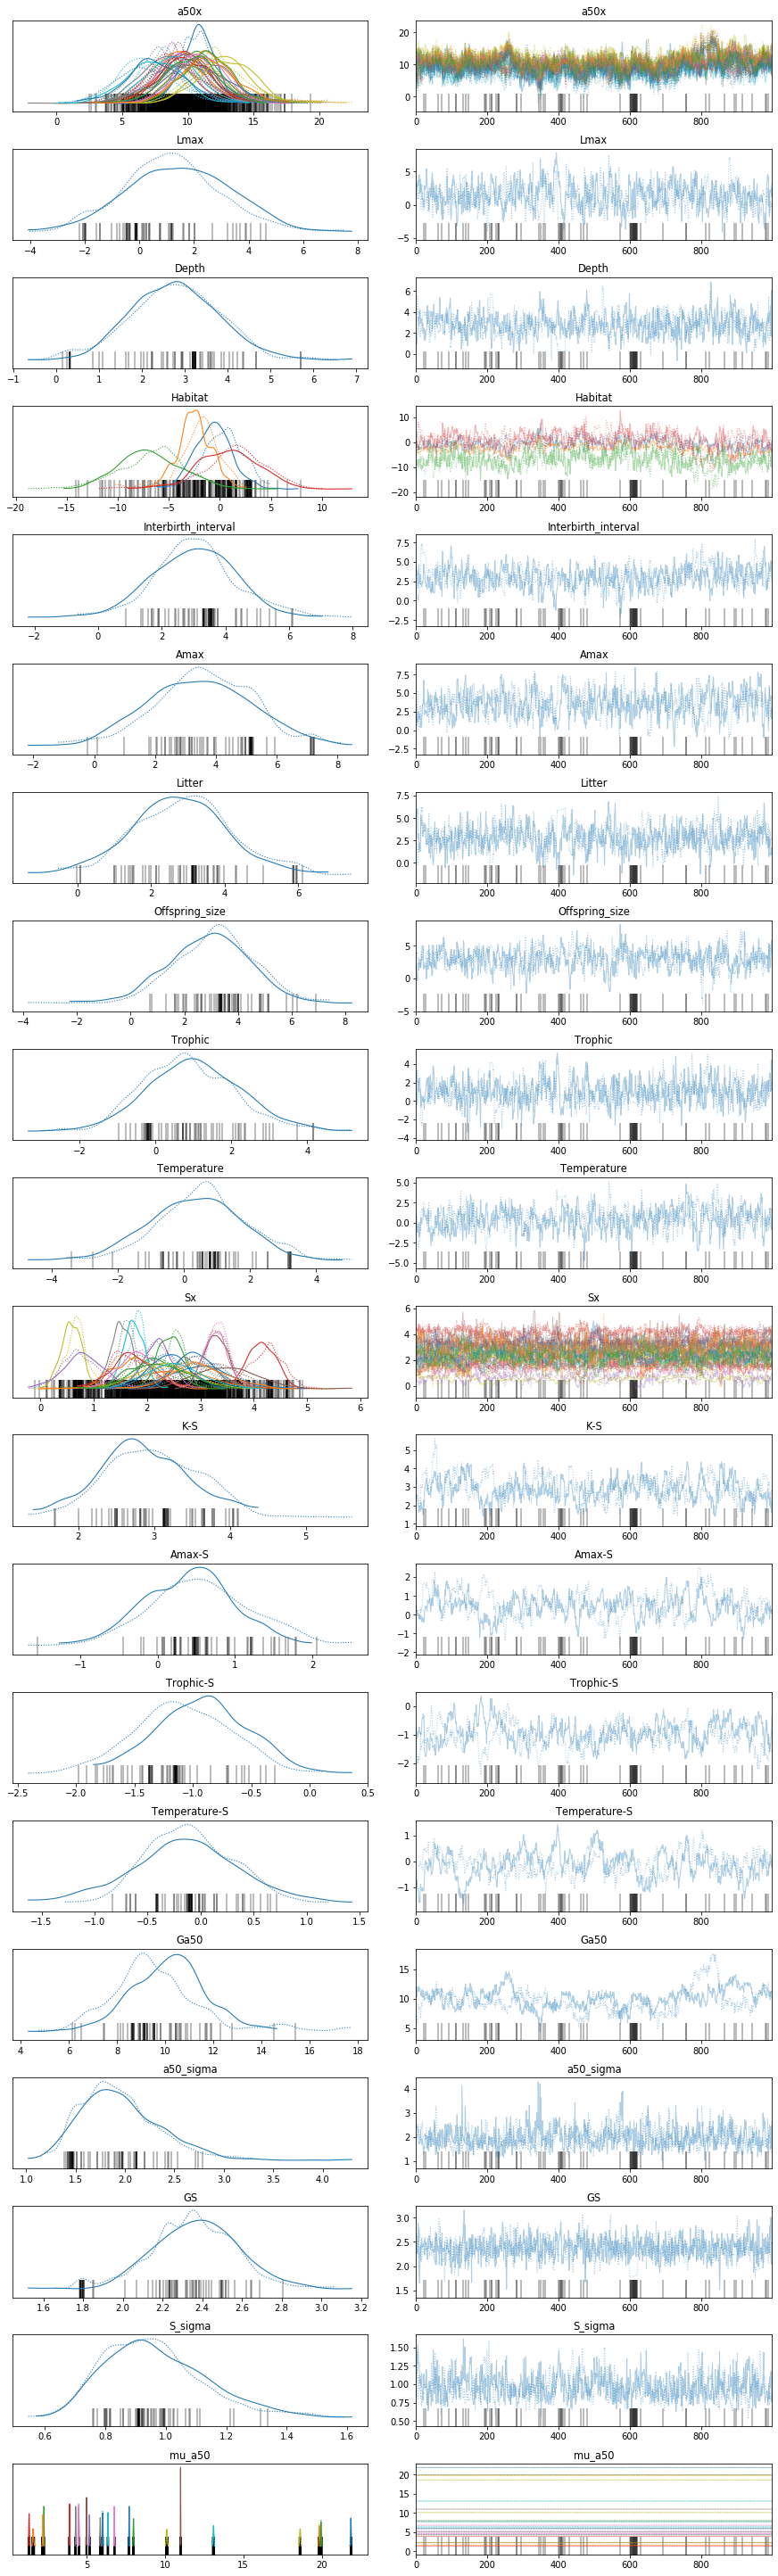

In [47]:
#check model performance
pm.traceplot(trace3);

In [48]:
pm.summary(trace3)
# looking for r-hat valeus of 1 - shows that model is converging

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  \
a50x[0]   10.822  1.314   8.389   13.347      0.121    0.090     118.0   
a50x[1]    9.230  2.167   5.099   13.232      0.336    0.243      42.0   
a50x[2]   10.461  2.157   6.500   14.583      0.340    0.245      40.0   
a50x[3]    9.515  2.157   5.551   13.641      0.340    0.246      40.0   
a50x[4]    9.168  2.111   5.063   12.916      0.324    0.239      43.0   
...          ...    ...     ...      ...        ...      ...       ...   
mu_S[19]   0.657  0.009   0.639    0.675      0.000    0.000    2030.0   
mu_S[20]   2.636  0.071   2.499    2.765      0.002    0.001    1517.0   
mu_S[21]   5.006  0.424   4.291    5.839      0.019    0.014     472.0   
mu_S[22]   1.196  0.024   1.155    1.241      0.001    0.000    1933.0   
S2         0.008  0.000   0.008    0.009      0.000    0.000     689.0   

          ess_sd  ess_bulk  ess_tail  r_hat  
a50x[0]    106.0     126.0     125.0   1.00  
a50x[1]     40.0      42.0      56.0   1.03  
a50x[2]     39.0      41.0      53.0   1.03  
a50x[3]     39.0      41.0      53.0   1.03  
a50x[4]     40.0      46.0      45.0   1.03  
...          ...       ...       ...    ...  
mu_S[19]  2030.0    2024.0    1091.0   1.00  
mu_S[20]  1502.0    1547.0    1137.0   1.00  
mu_S[21]   448.0     624.0     250.0   1.00  
mu_S[22]  1930.0    1946.0    1660.0   1.00  
S2         689.0     678.0     971.0   1.00  

[113 rows x 11 columns]

In [118]:
#Save traces for use in prediction
os.chdir('C:\\Users\\tmgor\\Dropbox\\Taylor Chapter 3\\Predict_Maturity\\Data\\for model\\out\\traces')
pm.save_trace(trace1)

'.pymc_8.trace'

In [53]:
pm.save_trace(trace2)

'.pymc_6.trace'

In [54]:
pm.save_trace(trace3)

'.pymc_7.trace'

### Model Results

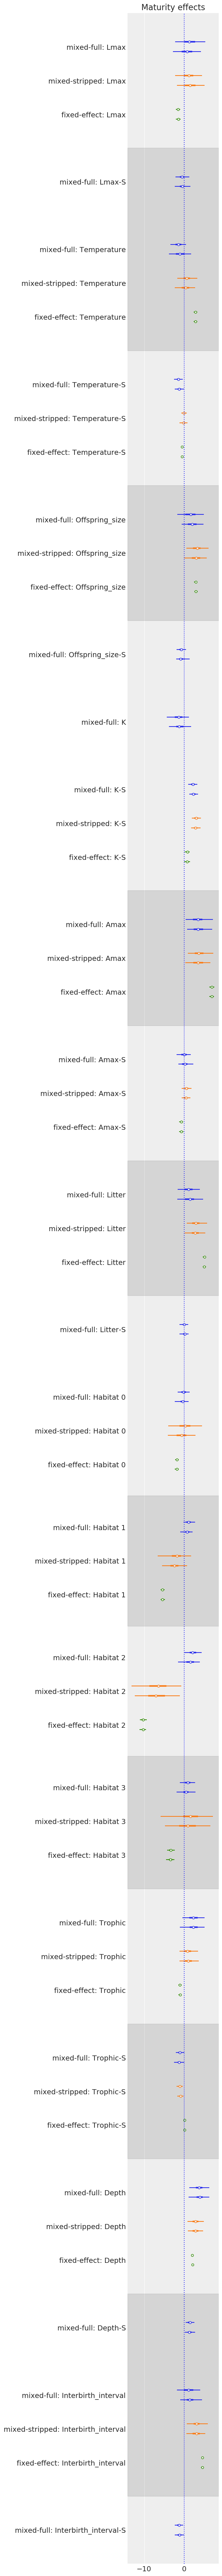

<Figure size 720x480 with 0 Axes>

In [117]:
# Forest plot to see size and direction of cov effects
# Compare mat1 and mat2 (mixed effect vs fixed effect)
az.style.use("arviz-darkgrid")
axes = az.plot_forest(
    [trace1,trace3,trace2], model_names=["mixed-full", "mixed-stripped", "fixed-effect"], var_names=["Lmax", "Lmax-S", "Temperature", "Temperature-S", "Offspring_size", "Offspring_size-S","K", "K-S", "Amax", "Amax-S", "Litter", "Litter-S", "Habitat", "Trophic", "Trophic-S", "Depth", "Depth-S", "Interbirth_interval", "Interbirth_interval-S"])
axes[0].set_title("Maturity effects")
plt.axvline(0, linestyle=':')
plt.show()

#save figure
os.chdir('C:\\Users\\tmgor\\Dropbox\\Taylor Chapter 3\\Predict_Maturity\\Data\\for model\\out')
plt.savefig('mat12&13&15_forest.jpg');

In [119]:
Hab

['pelagic-neritic', 'demersal', 'reef-associated', 'pelagic', 'benthopelagic']

### Model Comparison

In [64]:
#WAIC for model 1 (12)
pm.waic(trace1, scale='deviance')

Computed from 2000 by 505 log-likelihood matrix

              Estimate       SE
deviance_waic -3287.94   127.72
p_waic           90.95        -

There has been a warning during the calculation. Please check the results.

In [56]:
#WAIC for model 2 (13)
pm.waic(trace2, scale='deviance')

Computed from 2000 by 505 log-likelihood matrix

              Estimate       SE
deviance_waic  -681.21   105.55
p_waic           98.84        -

There has been a warning during the calculation. Please check the results.

In [57]:
#WAIC for model 3 (15)
pm.waic(trace3, scale='deviance')

Computed from 2000 by 505 log-likelihood matrix

              Estimate       SE
deviance_waic -3291.24   125.37
p_waic           88.71        -

There has been a warning during the calculation. Please check the results.

Model 12 WAIC = -3287  
Model 13 (fixed effect) WAIC = -681  
Model 15 WAIC = -3291

Model 15 is mostly closely fit 

#### Look for 'bad' datapoints

In [65]:
loo1 = pm.loo(trace1, mat1)
loo1

Computed from 2000 by 505 log-likelihood matrix

         Estimate       SE
elpd_loo  1636.91    62.95
p_loo       98.02        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      458   90.7%
 (0.5, 0.7]   (ok)         18    3.6%
   (0.7, 1]   (bad)        18    3.6%
   (1, Inf)   (very bad)   11    2.2%

In [30]:
# show bad datapoints
mdata.iloc[loo1.pareto_k.values > 1]

Species     Stock   Stock_Year  Age  maturity  \
42   Rhizoprionodon terraenovae  ATSH-NWA  ATSH-NWA-13    2  0.950000   
92       Carcharhinus acronotus  BNOS-NWA  BNOS-NWA-11    4  0.175100   
248     Carcharhinus brachyurus   COP-SWA   COP-SWA-03   21  0.236438   
249     Carcharhinus brachyurus   COP-SWA   COP-SWA-03   22  0.570582   
251     Carcharhinus brachyurus   COP-SWA   COP-SWA-03   24  0.881287   
434     Carcharhinus longimanus   OCW-WCP   OCW-WCP-12    4  0.341000   
515       Carcharhinus plumbeus   SAN-NWA   SAN-NWA-06   17  0.350000   
517       Carcharhinus plumbeus   SAN-NWA   SAN-NWA-06   19  0.600000   
519       Carcharhinus plumbeus   SAN-NWA   SAN-NWA-06   21  0.700000   
630     Carcharhinus brevipinna   SPIN-WP   SPIN-WP-05    7  0.142857   
631     Carcharhinus brevipinna   SPIN-WP   SPIN-WP-05    8  0.666667   

    survivorship  fecundity (num female pups per year)  \
42         0.768                                 0.978   
92        0.7911                                 2.500   
248          NaN                                   NaN   
249          NaN                                   NaN   
251          NaN                                   NaN   
434         0.82                                   NaN   
515          NaN                                 1.470   
517          NaN                                 2.520   
519          NaN                                 2.940   
630          NaN                                   NaN   
631          NaN                                   NaN   

                                                 notes  \
42   age 0 survivorship from section 3.2.6, alpha h...   
92                                 survivorship= 1-M;    
248                                                NaN   
249                                                NaN   
251                                                NaN   
434  litter size=6, natural mortality assumed to be...   
515                                                NaN   
517                                                NaN   
519                                                NaN   
630                                                NaN   
631                                                NaN   

                    model type     source_mat  ...     linf_cm growth_coeff_k  \
42   age-structured production      NMFS 2013  ...  118.500000       0.259120   
92   age-structured production      NMFS 2011  ...  179.779141       0.183633   
248                        NaN  Lucifora 2003  ...  272.000000       0.049000   
249                        NaN  Lucifora 2003  ...  272.000000       0.049000   
251                        NaN  Lucifora 2003  ...  272.000000       0.049000   
434            stock synthesis      WCPO 2012  ...  309.000000       0.101000   
515                        NaN      NMFS 2006  ...  250.666667       0.065499   
517                        NaN      NMFS 2006  ...  250.666667       0.065499   
519                        NaN      NMFS 2006  ...  250.666667       0.065499   
630                        NaN     Joung 2005  ...  288.000000       0.151000   
631                        NaN     Joung 2005  ...  288.000000       0.151000   

    lmax_cm age_max_yrs temp_pref  nursery depth_min depth_max depth_ave  \
42     81.3        10.0      25.5      0.0      10.0     280.0     145.0   
92    130.0        20.0      21.5      0.0       9.0      64.0      36.5   
248   275.0        34.5      17.4      0.0       0.0     360.0     180.0   
249   275.0        34.5      17.4      0.0       0.0     360.0     180.0   
251   275.0        34.5      17.4      0.0       0.0     360.0     180.0   
434   285.0        14.0      27.5      0.0       0.0     230.0     115.0   
515   204.0        34.0      27.2      0.0       0.0     500.0     250.0   
517   204.0        34.0      27.2      0.0       0.0     500.0     250.0   
519   204.0        34.0      27.2      0.0       0.0     500.0     250.0   
630   300.0        2

In [66]:
loo2 = pm.loo(trace2, mat2)
loo2

Computed from 2000 by 505 log-likelihood matrix

         Estimate       SE
elpd_loo   341.65    52.13
p_loo       97.79        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      468   92.7%
 (0.5, 0.7]   (ok)         23    4.6%
   (0.7, 1]   (bad)        11    2.2%
   (1, Inf)   (very bad)    3    0.6%

In [70]:
badpoints2 = mdata.iloc[loo2.pareto_k.values > 0.7]

In [68]:
loo3 = pm.loo(trace3, mat3)
loo3

Computed from 2000 by 505 log-likelihood matrix

         Estimate       SE
elpd_loo  1636.53    62.92
p_loo       97.80        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      457   90.5%
 (0.5, 0.7]   (ok)         19    3.8%
   (0.7, 1]   (bad)        18    3.6%
   (1, Inf)   (very bad)   11    2.2%

In [69]:
badpoints3 = mdata.iloc[loo3.pareto_k.values > 0.7]

### Plot model fits

In [71]:
# Save results to external file - mat1
result1 = pm.backends.tracetab.trace_to_dataframe(trace1)

# Edit column names
# Skip this step - seems unecessary & causes glitches
#colnames = np.array(list(result1.columns), dtype=object)

#colnames[np.array([list(colnames).index(x) for x in grep('a50x',colnames)])] = np.array(['a50_'+str(s) for s in StockYr])
#colnames[np.array([list(colnames).index(x) for x in grep('Sx',colnames)])] = np.array(['S_'+str(s) for s in StockYr])

#result1.columns = list(colnames)

# each model run produces an a50 and S value for each stock-year
os.chdir('C:\\Users\\tmgor\\Dropbox\\Taylor Chapter 3\\Predict_Maturity\\Data\\for model\\out')
result1.to_csv('mat12_model_results.csv')
result1.head()

a50x__0   a50x__1   a50x__2   a50x__3   a50x__4   a50x__5   a50x__6  \
0  6.837797  5.749044  4.265806  3.306914  5.204542  5.033253  4.540811   
1  6.887541  6.540968  4.759371  3.808701  5.312765  5.111443  4.608831   
2  8.210170  6.477644  5.465935  4.504480  4.740837  4.763656  4.258265   
3  7.578090  5.918819  6.367641  5.429497  5.299557  5.586277  5.102198   
4  8.044484  5.664340  5.862699  4.912964  5.299126  5.560841  5.095364   

    a50x__7   a50x__8   a50x__9  ...  mu_S__14  mu_S__15  mu_S__16  mu_S__17  \
0  4.506218  8.786389  5.051611  ...  1.489902  7.719632  2.123519  2.268581   
1  4.333026  8.577976  4.889460  ...  1.503768  6.844269  2.023641  2.226292   
2  4.543440  8.756805  5.066810  ...  1.534670  4.282504  2.123774  2.229693   
3  5.016694  9.277049  5.533675  ...  1.527881  6.655586  2.048407  2.178276   
4  5.265491  9.480813  5.768587  ...  1.558632  5.167902  2.132455  2.229685   

   mu_S__18  mu_S__19  mu_S__20  mu_S__21  mu_S__22        S2  
0  0.486408  0.648984  2.570847  5.152910  1.189385  0.008096  
1  0.479167  0.676452  2.575443  5.061194  1.167025  0.008142  
2  0.477482  0.685967  2.673056  4.730367  1.177562  0.008351  
3  0.497140  0.646553  2.606056  5.312420  1.210289  0.008813  
4  0.486351  0.666584  2.614089  4.717383  1.177103  0.008647  

[5 rows x 123 columns]

In [73]:
# Save results to external file - mat2
result2 = pm.backends.tracetab.trace_to_dataframe(trace2)
result2.to_csv('mat13_model_results.csv')

In [74]:
# Save results to external file - mat3
result3 = pm.backends.tracetab.trace_to_dataframe(trace3)

# each model run produces an a50 and S value for each stock-year
os.chdir('C:\\Users\\tmgor\\Dropbox\\Taylor Chapter 3\\Predict_Maturity\\Data\\for model\\out')
result3.to_csv('mat15_model_results.csv')
result3.head()

a50x__0    a50x__1    a50x__2    a50x__3    a50x__4    a50x__5  \
0  12.730497   8.685257  10.485923   9.544780  11.129771  11.622510   
1  12.620220   9.760149  11.455289  10.493869  10.008751  10.488175   
2  11.100418  10.035690  11.904422  10.959698  10.187079  10.651861   
3  11.706043  10.349531  12.124567  11.185901   9.928186  10.412203   
4  11.824021   9.417785  11.286227  10.353464   9.721224  10.207579   

     a50x__6    a50x__7    a50x__8    a50x__9  ...  mu_S__14  mu_S__15  \
0  11.123935   8.704430  12.900136   9.167811  ...  1.540868  4.826762   
1  10.003097   9.358562  13.546017   9.855464  ...  1.545849  5.067923   
2  10.163336   9.986305  14.181974  10.477021  ...  1.543010  5.388852   
3   9.917685   9.639309  13.858962  10.128021  ...  1.564960  5.565608   
4   9.711414  10.529077  14.789535  11.013761  ...  1.568094  4.762061   

   mu_S__16  mu_S__17  mu_S__18  mu_S__19  mu_S__20  mu_S__21  mu_S__22  \
0  2.114988  2.265671  0.488218  0.670691  2.468451  4.906278  1.250003   
1  2.139421  2.287075  0.485585  0.650680  2.841079  4.488168  1.225414   
2  2.209788  2.218236  0.499849  0.655998  2.721400  5.026436  1.230047   
3  1.982715  2.309524  0.470495  0.641305  2.558958  5.567785  1.218389   
4  2.219668  2.253467  0.471570  0.649789  2.735259  5.307406  1.197365   

         S2  
0  0.008336  
1  0.008682  
2  0.008507  
3  0.008547  
4  0.008877  

[5 rows x 113 columns]

In [102]:
# Grab data from mat1 results (model 12)
# Grab a50's
# take median mu_a50 value for each stock-year to visualise effect of covs on a50
μa50s = np.array([np.median(result1[x]) for x in np.array(['mu_a50__'+str(s) for s in list(range(len(StockYr)))])]).T

# can also just look at a50s (no effect of covariates)
a50s = np.array([np.median(result1[x]) for x in np.array(['a50x__'+str(s) for s in list(range(len(StockYr)))])]).T

# Grab S's
μSs = np.array([np.median(result1[x]) for x in np.array(['mu_S__'+str(s) for s in list(range(len(StockYr)))])]).T
Ss = np.array([np.median(result1[x]) for x in np.array(['Sx__'+str(s) for s in list(range(len(StockYr)))])]).T

# xrange
xr = np.linspace(0,max(AGE),max(AGE).astype(int)+1)

In [103]:
#Grab data from mat2 (model 13 results)
# take median mu_a50 value for each stock-year to visualise effect of covs on a50
μa50s2 = np.array([np.median(result2[x]) for x in np.array(['mu_a50__'+str(s) for s in list(range(len(StockYr)))])]).T


# Grab S's
μSs2 = np.array([np.median(result2[x]) for x in np.array(['mu_S__'+str(s) for s in list(range(len(StockYr)))])]).T

# xrange
# Make a vector of ages from 0 to max age
xr = np.linspace(0,max(AGE),max(AGE).astype(int)+1)

In [107]:
# Grab data from mat3 results (model 15)
# Grab a50's
# take median mu_a50 value for each stock-year to visualise effect of covs on a50
μa50s3 = np.array([np.median(result3[x]) for x in np.array(['mu_a50__'+str(s) for s in list(range(len(StockYr)))])]).T

# can also just look at a50s (no effect of covariates)
#a50s3 = np.array([np.median(result3[x]) for x in np.array(['a50_'+str(s) for s in StockYr])]).T
a50s3 = np.array([np.median(result3[x]) for x in np.array(['a50x__'+str(s) for s in list(range(len(StockYr)))])]).T

# Grab S's
μSs3 = np.array([np.median(result3[x]) for x in np.array(['mu_S__'+str(s) for s in list(range(len(StockYr)))])]).T
S3s = np.array([np.median(result3[x]) for x in np.array(['Sx__'+str(s) for s in list(range(len(StockYr)))])]).T

# xrange
xr = np.linspace(0,max(AGE),max(AGE).astype(int)+1)

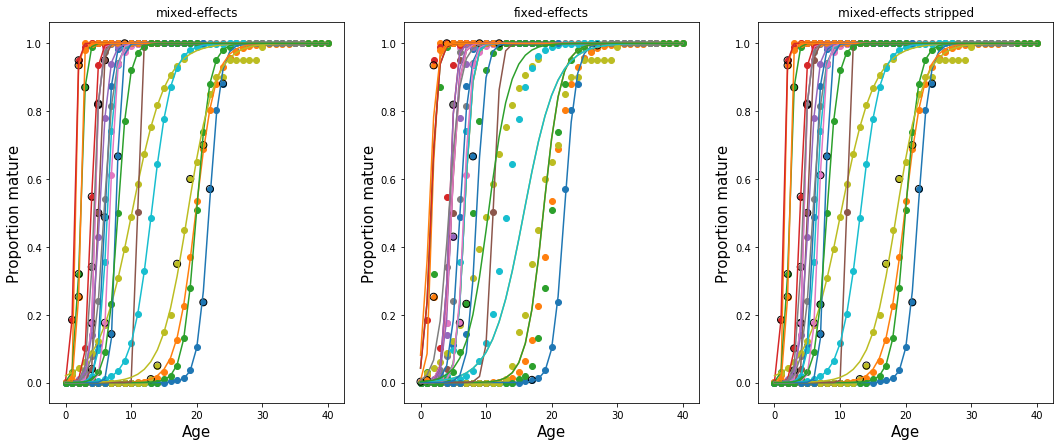

In [111]:
#set up figure
nrows, ncols = 1, 3
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(18,7))
ax_ = axes.flatten()

#Plot mat12
#scatter plot of mat and age data
[ax_[0].scatter(AGE[mdata.Stock_Year.values==s], MAT[mdata.Stock_Year.values==s]) for s in StockYr]
# add markers for points with bad pareto k scores
ax_[0].scatter(badpoints1.Age, badpoints1.maturity, facecolors='none', edgecolors='k', s=50)
#plot ogives with median S and mu_a50 values
[ax_[0].plot(xr, 1/(1+np.exp(-s*(xr-a)))) for s,a in zip(μSs,μa50s)]
#make plot pretty
ax_[0].set_xlabel('Age',fontsize=15)
ax_[0].set_ylabel('Proportion mature',fontsize=15)
ax_[0].set_title('mixed-effects')

#Plot mat13
#scatter plot of mat and age data
[ax_[1].scatter(AGE[mdata.Stock_Year.values==s], MAT[mdata.Stock_Year.values==s]) for s in StockYr]
# add markers for poitns with high pareto k scores
ax_[1].scatter(badpoints2.Age, badpoints2.maturity, facecolors='none', edgecolors='k', s=50)
#plot ogives with median S and mu_a50 values
[ax_[1].plot(xr, 1/(1+np.exp(-s*(xr-a)))) for s,a in zip(μSs2,μa50s2)]
#make plot pretty
ax_[1].set_xlabel('Age',fontsize=15)
ax_[1].set_ylabel('Proportion mature',fontsize=15)
ax_[1].set_title('fixed-effects')

#Plot mat15
#scatter plot of mat and age data
[ax_[2].scatter(AGE[mdata.Stock_Year.values==s], MAT[mdata.Stock_Year.values==s]) for s in StockYr]
# add markers for points with bad pareto k scores
ax_[2].scatter(badpoints3.Age, badpoints3.maturity, facecolors='none', edgecolors='k', s=50)
#plot ogives with median S and mu_a50 values
[ax_[2].plot(xr, 1/(1+np.exp(-s*(xr-a)))) for s,a in zip(μSs3,μa50s3)]
#make plot pretty
ax_[2].set_xlabel('Age',fontsize=15)
ax_[2].set_ylabel('Proportion mature',fontsize=15)
ax_[2].set_title('mixed-effects stripped')

#save results
plt.savefig('mat12_mat13_mat15_modelfit.jpg',dpi=300);

Text(0, 0.5, 'Proportion mature')

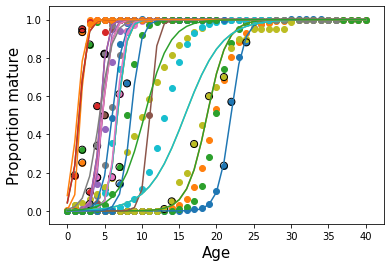

In [112]:
#plot model results against raw data - single plot model 1

#scatter plot of mat and age data
[plt.scatter(AGE[mdata.Stock_Year.values==s], MAT[mdata.Stock_Year.values==s]) for s in StockYr]
#plot ogives with median S and mu_a50 values
[plt.plot(xr, 1/(1+np.exp(-s*(xr-a)))) for s,a in zip(μSs2,μa50s2)]
# plot bad datapoints
plt.scatter(badpoints3.Age, badpoints3.maturity, facecolors='none', edgecolors='k', s=50)
#make plot pretty
plt.xlabel('Age',fontsize=15)
plt.ylabel('Proportion mature',fontsize=15)